# Deep learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Murcha1990/ML_math_2022/blob/main/Семинары/sem14-neural-networks.ipynb)

![just add more layers](https://preview.redd.it/5193db0avbey.jpg?auto=webp&v=enabled&s=16e07a5eaabe7f85e191c16b49a8209d92336e65)

In [65]:
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST



def load_mnist(dir: str = "data", cache: bool = True, flatten: bool = True):
    train_data = MNIST(dir, train=True, download=True)
    test_data = MNIST(dir, train=False, download=True)
    
    def load_fold(dataset, flatten=True):
        X, y = [], []
        for image, target in dataset:
            X.append(np.asarray(image) / 255.)
            y.append(target)
        X = np.stack(X)
        if flatten: 
            X = X.reshape(X.shape[0], -1)
        return X, np.array(y)
    
    X_train, y_train = load_fold(train_data)
    X_test, y_test = load_fold(test_data)

    if not cache:
        os.unlink(dir)

    return X_train, X_test, y_train, y_test

def plot(image: np.ndarray, target=None, ax=None):
    ax = ax or plt.gca()
    ax.imshow(image.reshape(28, 28))
    if target is not None:
        ax.set_title(target)
    ax.axis("off")

## MNIST Распознавание рукописных цифр

In [66]:
X_train, X_test, y_train, y_test = load_mnist(flatten=True)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

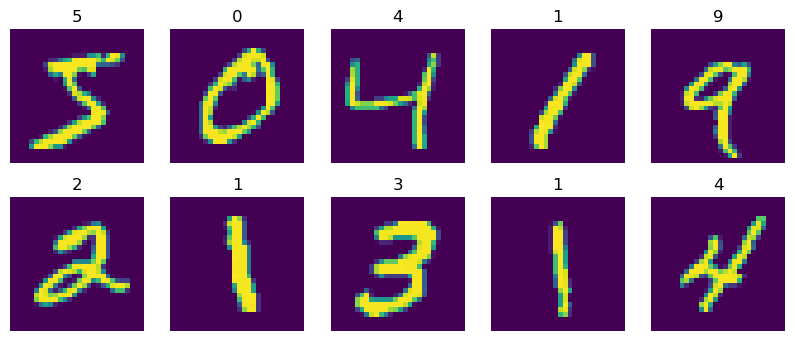

In [67]:
_, axes = plt.subplots(2, 5, figsize=(10, 4))

for img, tgt, ax in zip(X_train, y_train, axes.flatten()):
    plot(img, tgt, ax)


### Бейзлайн

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [56]:
lr = LogisticRegression(n_jobs=-1)

lr.fit(X_train.reshape(-1, 28 * 28), y_train)

/Users/max-nekrash/miniconda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
lr.score(X_test.reshape(-1, 28 * 28), y_test)

0.9258

## Нейронные сети

![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)

**Идея:** Линейная регрессия поверх линейной регрессии (поверх линейной регрессии).

$$
y = argmax\bigg(f_3\Big(f_2\big(f_1(x)\big)\Big)\bigg)
$$


*Если $f_i(x) = w_ix + b_i$, в чём проблема?* 
<details> 
  <summary>Спойлер</summary>
    Композиция линейных функций - линейная функция.
</details>

### Функции активации

![activation_functions](https://www.researchgate.net/profile/Aaron-Stebner-2/publication/341310767/figure/fig7/AS:890211844255749@1589254451431/Common-activation-functions-in-artificial-neural-networks-NNs-that-introduce.ppm)

Нужны, чтобы модель перестала быть линейной. Чаще всего берут $ReLU$ или $LeakyReLU$.


В конце применим к выходам модели softmax, чтобы можно было интерпретировать предсказания как вероятности.

**Итого:** модель имеет вид
$$
p = softmax(a) = softmax(w_3\sigma(w_2\sigma(w_1x + b_1) + b_2) + b_3)
$$
$a$ называются логитами

Есть ещё слои:
* Dropout
* Batch/layer normalization
* Convolution
* Recurrent layer
* Attention
* ...

### Как это всё учить?

**Нужно:**
1. Лосс-функция (Кросс-энтропия)

    Запишем кросс-энтропию, как функцию от логитов.

    $$
    loss = -\sum_i\log\frac{\exp(a_{correct, i})}{\sum_k\exp(a_{k,i})}
    $$

    *Это выражение можно упростить (как?)*

    В таком виде оно более вычислительно стабильно и его проще дифферинцировать

2. Метод оптимизации (SGD, Adam)

    Решаем задачу $loss(f(X, w), y) \to \min_w$. Если $f$ - линейная регрессия, то знаем как. (Как?)

    Чтобы применить такой же подход надо научиться брать производные.

    Метод называется ~~производная композиции~~ backpropogation.


**Итоговый метод:**

`while True:`
1. Применяем модель
2. Считаем лосс
3. Получаем градиенты
4. Обновляем веса

**Даже это есть в sklearn**

In [60]:
from sklearn.neural_network import MLPClassifier

In [62]:
mlp = MLPClassifier(max_iter=100)

mlp.fit(X_train.reshape(-1, 28 * 28), y_train)

MLPClassifier()

In [63]:
mlp.score(X_test.reshape(-1, 28 * 28), y_test)

0.9786

### DIY часть

Будем писать свою нейросеть. На `numpy`.

In [ ]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [ ]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    - Process input to get output:           output = layer.forward(input)
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Активация

In [ ]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        # <your code>
        return grad_input

In [ ]:
# some tests

x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Линейный слой

In [ ]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <x*W> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <x*W> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return #<your code here>
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = #<your code here>
        
        # compute gradient w.r.t. weights and biases
        grad_weights = #<your code here>
        grad_biases = #<your code here>
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Тесты на линейный слой

Если тесты падают:

<details> 
  <summary>Спойлер</summary>
    <ul>
        <li> Убедитесь, что градиенты для b - это сумма градиентов по батчу. Grad_output уже поделён на размер батча.
        <li> Попробуйте сохранять переменные в аттрибут класса "self.grad_w = grad_w" или печатайте какие-то веса. Это помогает с дебагом.
        <li> Если тесты всё расно падают, попробуйте их пропустить и приступить к обучению сети, возможно, эта ошибка не повлияет на само обучение.
    </ul>
</details>


In [ ]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

In [ ]:
# To test the grads, we use gradients obtained via finite differences

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

In [ ]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

In [ ]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

### Лосс-функция

In [ ]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]

    xentropy = # <your code here>

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""

    return # <your code here>

In [ ]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50) % 10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads, grads, rtol=1e-3, atol=0), \
    "The reference implementation has just failed. Someone has just changed the rules of math."


### Бонус: Напишите Dropout слой

### Собираем всё вместе

In [ ]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

In [ ]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    # <your code here>

    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [ ]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first, 
    propagating the gradient of input to previous layers.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    <YOUR CODE>
        
    return np.mean(loss)

In [ ]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
from IPython.display import clear_output
train_log = []
val_log = []

In [ ]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()